In [3]:
import requests
import json
import subprocess
import matplotlib.pyplot as plt

# Estructura component

El component ha de poder executar un codi agnòstic. Es pot començar simplificant el problema fent que aquest codi agnòstic està dins d'un arxiu .py.  
Aquest arxiu .py estarà dins d'un docker.  
El docker estarà montat amb una base de fastapi.  
La crida al component, hauria d'aixecar el docker, amb uns paràmetres d'entrada. El docker executaria el codi .py, i automàticament enviaria el resultat de l'execució de tornada mitjançant fastapi  

Patrón de diseño Command Pattern

# Component V1

docker build -t componente-v1.0 -f Dockerfile .

docker run -e SCRIPT_PATH=/path/to/script.py -e ARGS="arg1 arg2 arg3" -e URL=http://api-access-manager.com/path componente-v1.0



docker run -it --rm mi-imagen python /tests/componente_tests.py

"calculos.py" debe enviar por stdout los resultados del cálculo en formato json (o str en su defecto).



## Crides

In [8]:
resultado = {"data": {"a" : 1}}
url = "http://localhost:8080/run"
headers = {"Content-Type": "application/json"}
response = requests.post(url, headers=headers, data=json.dumps(resultado))
print(response)
print(response.text)

<Response [200]>
{"status":1000}


In [132]:
url = "http://localhost:8080/results"
headers = {"Content-Type": "application/json"}
resultado =  { "a" : 1 }
response = requests.post(url, headers=headers, data=json.dumps(resultado))
json.dumps(resultado)

'{"a": 1}'

In [118]:
docker_image_name = "componente-v1.0"
script_path = "calculos.py"
args = "arg1 arg2 arg3"
url = "http://host.docker.internal:8080/results"
docker_command = ["docker", "run", "-e", f"SCRIPT_PATH={script_path}", "-e", f'ARGS="{args}"', "-e", f'URL={url}', docker_image_name]
process = subprocess.run(docker_command)
process

CompletedProcess(args=['docker', 'run', '-e', 'SCRIPT_PATH=calculos.py', '-e', 'ARGS="arg1 arg2 arg3"', '-e', 'URL=http://host.docker.internal:8080/results', 'componente-v1.0'], returncode=0)

In [34]:
docker_image_name = "componente-v1.0"
script_path = "calculos.py"
args = "arg1 arg2 arg3"
url = "http://host.docker.internal:8080/results"
docker_command = f'docker run -e SCRIPT_PATH={script_path} -e ARGS="{args}" -e URL={url} {docker_image_name}'
process = subprocess.run(docker_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE,text=True)

'{"a": 1}'

In [46]:
script_path = "..\src\componente_v1\calculos.py"
try:
    with open(script_path, 'r') as file:
        print('El archivo calculos.py es accesible')
except FileNotFoundError:
    print('El archivo calculos.py no es accesible')

El archivo calculos.py es accesible


## Howto


* Construir imagen  
docker build -t componente-v1.0 -f Dockerfile .

* Para abrir el access manager   
python access_manager_simulation.py




* Para utilizar terminal dentro del contenedor (principalmente debugguear)  
docker run -it componente-v1.0 bash


In [4]:
script_name = "script_1_calculadora.py"
script_arguments = "2 3"

data = {"script_path": script_name, "arguments": script_arguments}
run_script_url = "http://localhost:8080/run"
headers = {"Content-Type": "application/json"}
response = requests.post(run_script_url, headers=headers, json=data)
print(response, response.text)

<Response [202]> {"status":"started","PID":5560}


## Modificacions  

* No s'executarà codi aliè.  
* Dos approaches, T2.3 i T2.4
* No s'executarà un docker per procés, els processos menys intensos seràn scripts a l'entorn
  que s'executaràn. Els més intensos sí que es faràn en un contenidor apart.


## Jofre: Preguntar cas d'us?  
  * Qui és?
  * Què ens ha proporcionat?
  * Quin context necessito per formular una pregunta més coherent informativa que "Com ho utilitzaries?"
## Diagrama de sqüència: Com faràn les dades? Per on passaràn?
  * Com faràn les dades?
  * Per on passaràn?
  * Visio?


# Component v2


Para construir el contenedor:
> docker build -t componente-v2 -f Dockerfile .  

Para correr el contenedor:  
> docker run -p 8000:8000 componente-v2  
 
Si quiero tener la unidad montada en /datasets para ver el resultado  
> docker run -p 8000:8000 -v C:\Users\ian.palacin\Desktop\projects\IMPETUS\src\componente_v2\datasets:/app/datasets componente-v2

De esta forma se ejecuta el comando ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8000"], que deja corriendo una api en el contenedor, esta será la responsable de recibir órdenes. La api está en main.py, desde allí se orquestará la:
* Recepción de órdenes des del Acess Manager (de momento simulado)
* Ejecución del proceso
* Envío de la salida del proceso de vuelta al Access Manager


### Development

Component
> uvicorn main:app --host 0.0.0.0 --port 8000 --reload  

Clean procedure  
>python procedures\clean_procedure.py datasets\racha_max_manresa_2_columns_api.json --output_path datasets\out.csv

# INTERFICIE

In [6]:
import requests
import json
import pandas as pd
import plotly.graph_objects as go

In [86]:
# Vull processar les meves dades amb el procés de data cleaning
url = "http://127.0.0.1:8080/run"
headers = {"Content-Type": "application/json"}
payload = { 
    "script_name": "clean_procedure.py",
    "args": ["datasets/racha_max_manresa_2_columns_api.json",  "--output_path", "datasets/out1.csv"]
    # "args": ["datasets/racha_max_manresa_2_columns.json",  "--output_path", "datasets/out3.csv"]
}
response = requests.post(url, headers=headers, data=json.dumps(payload))
print(response)
print(response.text)

<Response [200]>
{"message":"Ejecutando clean_procedure.py con argumentos: datasets/racha_max_manresa_2_columns.json --output_path datasets/out3.csv"}


In [67]:
df_racha_raw = pd.read_csv( "..\src\componente_v2\datasets\\racha_max_manresa_2_columns.csv")
# df_racha_processed = pd.read_csv( "..\src\componente_v2\datasets\\racha_max_manresa_20230809_110038.csv")
# df_racha_processed = pd.read_csv( "..\src\componente_v2racha_max_manresa_20230810_091920.csv")
df_racha_processed = pd.read_csv(r"C:\Users\ian.palacin\Desktop\projects\IMPETUS\src\componente_v2\datasets\out2.csv")

In [68]:
trace_raw = go.Scatter(x=df_racha_raw.index, y=df_racha_raw['RachaMax'], mode='lines', name='Raw')
trace_processed = go.Scatter(x=df_racha_processed.index, y=df_racha_processed['RachaMax'], mode='lines', name='Processed')
fig = go.Figure(data=[trace_raw, trace_processed])
fig.show()

# Lab

In [24]:
a = [['ZScoreOutlierMask', 2], ['ZeroMaskImputation']]
# b = [','.join(str(m)) for m in a]
c = ['ZScoreOutlierMask', 2]
", ".join([" ".join([str(e) for e in y]) for y in a ])
# ", ".join(str(c))


'ZScoreOutlierMask 2, ZeroMaskImputation'

In [ ]:
import pandas as pd
df = pd.read_excel( r"..\src\componente_v2\datasets\viento_manresa.xlsx" )
df = df[['FECHA', 'Racha Max (Km/h)']]
df.to_csv(r"..\src\componente_v2\datasets\racha_max_manresa.csv")



# Mask logic developement

In [25]:
class ZScoreOutlierRemoval(cp.DataCleaningMethod):
    
    def __init__(self, threshold=2):
        self.threshold = threshold

    def clean(self, data):
        z_scores = np.abs(stats.zscore(data))
        mask = (z_scores < self.threshold)
        data_processed = data[mask]
        return data_processed


NameError: name 'cp' is not defined

In [ ]:
config_json_path = r"C:\Users\ian.palacin\Projectes\impetus-utils\src\componente_v2\datasets\racha_max_manresa_2_columns_api.json"
with open(config_json_path) as f:
    config = json.load(f)
    
cleaner = cp.DataCleaner(data_source_type=config['data_source_type'], data_source=config['data_source'], config=config)
df_pre_clean = cleaner.load_data_from_api(config['data_source'], config['api_additional_info'])
# cleaner.load_data()
# cleaner.clean_data(config["methods"])
# df_clean = cleaner.data

In [ ]:
# df = df_pre_clean.copy()
timedelta =  (df.index.to_series() - df.index.to_series().shift(1))
timedelta


date_observed
2011-01-14 00:00:00               NaT
2011-01-15 00:00:00   1 days 00:00:00
2011-01-16 00:00:00   1 days 00:00:00
2011-01-17 00:00:00   1 days 00:00:00
2011-01-18 00:00:00   1 days 00:00:00
                            ...      
2022-12-27 00:10:00   0 days 08:30:00
2022-12-28 18:40:00   1 days 18:30:00
2022-12-29 17:50:00   0 days 23:10:00
2022-12-30 13:20:00   0 days 19:30:00
2022-12-31 03:20:00   0 days 14:00:00
Name: date_observed, Length: 4261, dtype: timedelta64[ns]

In [ ]:
import numpy as np

a = [1,2,3,2]
mask = [True,False,True,False]
array = np.where(mask, 0, a)
array

array([0, 2, 0, 2])

In [ ]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Plotting result of clean_procedure.py

In [1]:
import sys
import pandas as pd
import json
import matplotlib.pyplot as plt
sys.path.insert(0, r'C:\Users\ian.palacin\Projectes\impetus-utils\src\componente_v2')
import procedures.clean_procedure as cp

In [9]:
config_json_path = r"C:\Users\ian.palacin\Projectes\impetus-utils\src\componente_v2\datasets\racha_max_manresa_3_columns_api.json"
with open(config_json_path) as f:
    config = json.load(f)

In [10]:
config

{'data_source_type': 'api',
 'data_source': 'https://data-manager.climate-impetus.eu/access/historical/entities',
 'api_additional_info': {'start_time': '2011-01-14T00:00:00',
  'end_time': '2023-01-20T00:00:00',
  'entity_type': 'WindSensor',
  'format': 'COLUMN',
  'origin': 'DEVICE'},
 'methods': {'max_wind_gust': [[['ZScoreOutlierMask', 1],
    ['MeanMaskImputation']]]}}

In [11]:
cleaner = cp.DataCleaner(data_source_type=config['data_source_type'], data_source=config['data_source'], config=config)
df_pre_clean = cleaner.load_data_from_api(config['data_source'], config['api_additional_info'])
cleaner.load_data()
cleaner.clean_data(config["methods"])
df_clean = cleaner.data

DATA SOURCE https://data-manager.climate-impetus.eu/access/historical/entities
1 dict_items([('max_wind_gust', [[['ZScoreOutlierMask', 1], ['MeanMaskImputation']]])])
[['ZScoreOutlierMask', 1], ['MeanMaskImputation']]


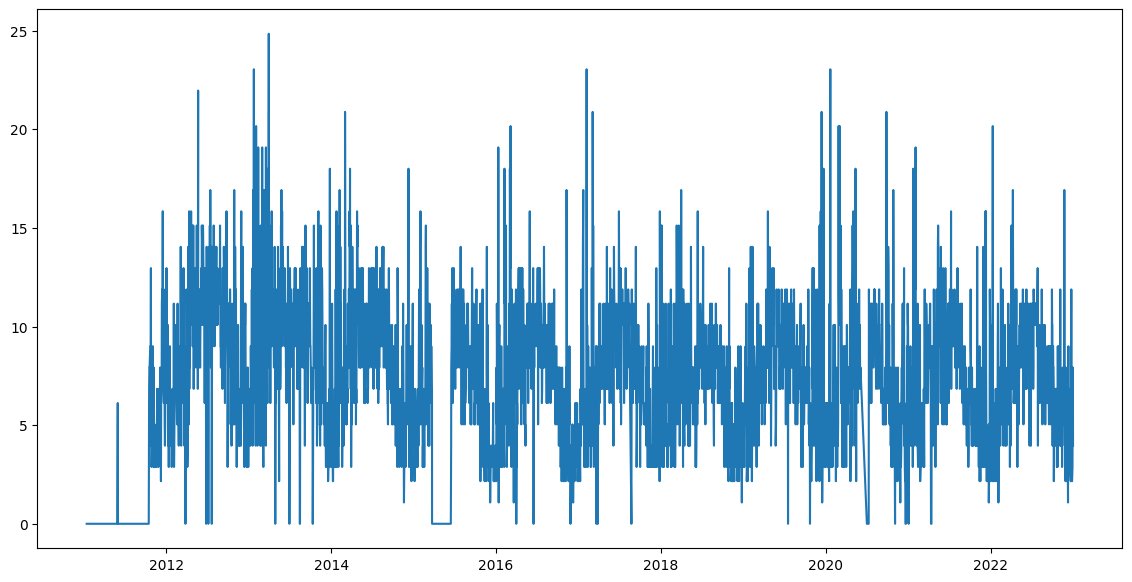

In [17]:
# df_joint = pd.DataFrame( {"avg_speed_raw": df_pre_clean['avg_speed'], "avg_speed_processed":df_clean['avg_speed']} )
df_joint = pd.DataFrame( {"avg_speed_raw": df_pre_clean['avg_speed'], "avg_speed_processed":df_clean['avg_speed']} )
_ = plt.figure( figsize =(14, 7))
# _ = plt.plot(df_joint)
_ = plt.plot(df_pre_clean['avg_speed'])
# _ = plt.plot(df_clean['avg_speed'])

# Streamlit v1

In [1]:
general_functions = []  # Tus funciones generales
mask_generators = ["ZScoreOutlierMask"]  # Generadores de máscaras
mask_imputators = ["ZeroMaskImputation"]  # Imputadores específicos de máscaras
# data = {
#   "arg_0_1": 3,
#   "function_0_1": "ZScoreOutlierMask",
#   "function_0_3": "ZScoreOutlierMask",
#   "imputator_0_4": "ZeroMaskImputation",
#   "variable_0_0": "avg_speed",
#   "arg_0_3": 4,
#   "imputator_0_2": "ZeroMaskImputation"
# }

data = {
  "arg_0_1": 3,
  "function_0_1": "ZScoreOutlierMask",
  "variable_0_0": "avg_speed",
  "imputator_0_2": "ZeroMaskImputation",
  "variable_1_0": "max_wind_gust",
  "imputator_1_2": "ZeroMaskImputation",
  "function_1_1": "ZScoreOutlierMask",
  "arg_1_1": 4
}


In [261]:
values_to_variables = {0: "variable", 1: 'function', 2: 'imputator', 3:'arg'}
variables_to_values = {y: x for x, y in values_to_variables.items()}

elementwise_config = [[variables_to_values[key.split("_")[0]], int(key.split("_")[1]), int(key.split("_")[2])] for key in data.keys()]
elementwise_config.sort(key = lambda row: (row[1],row[2], row[0]))
elementwise_config = [ "_".join([values_to_variables[x],str(y),str(z)]) for [x,y,z] in elementwise_config ]
arg_grouped_list, i = [], 0
while i <= len(elementwise_config)-1:
    if i + 1 < len(elementwise_config) and 'arg_' in elementwise_config[i + 1]:
        arg_grouped_list.append([elementwise_config[i], elementwise_config[i + 1]])
        i += 1
    else:
        arg_grouped_list.append([elementwise_config[i]])
    i += 1

final_list, i = [], len(arg_grouped_list)-1
while i >= 0:
    if 'imputator' in arg_grouped_list[i][0]:
        final_list.append([arg_grouped_list[i-1], arg_grouped_list[i]])
        i -= 1
    else:
        final_list.append([arg_grouped_list[i]])
    i -= 1
final_list = final_list[::-1]
variable = final_list[0][0][0]
methods = [[ [data[component_of_function] for component_of_function in function_with_args] for function_with_args in list_of_functions] for list_of_functions in final_list[1:]]
methods

[[['ZScoreOutlierMask', 3], ['ZeroMaskImputation']],
 [['max_wind_gust']],
 [['ZScoreOutlierMask', 4], ['ZeroMaskImputation']]]

In [9]:
def parse_variable_form_to_method(data):
    values_to_variables = {0: "variable", 1: 'function', 2: 'imputator', 3:'arg'}
    variables_to_values = {y: x for x, y in values_to_variables.items()}

    elementwise_config = [[variables_to_values[key.split("_")[0]], int(key.split("_")[1]), int(key.split("_")[2])] for key in data.keys()]
    elementwise_config.sort(key = lambda row: (row[1],row[2], row[0]))
    elementwise_config = [ "_".join([values_to_variables[x],str(y),str(z)]) for [x,y,z] in elementwise_config ]
    arg_grouped_list, i = [], 0
    while i <= len(elementwise_config)-1:
        if i + 1 < len(elementwise_config) and 'arg_' in elementwise_config[i + 1]:
            arg_grouped_list.append([elementwise_config[i], elementwise_config[i + 1]])
            i += 1
        else:
            arg_grouped_list.append([elementwise_config[i]])
        i += 1

    final_list, i = [], len(arg_grouped_list)-1
    while i >= 0:
        if 'imputator' in arg_grouped_list[i][0]:
            final_list.append([arg_grouped_list[i-1], arg_grouped_list[i]])
            i -= 1
        else:
            final_list.append([arg_grouped_list[i]])
        i -= 1
    final_list = final_list[::-1]
    column = data[final_list[0][0][0]]
    methods = [[ [data[component_of_function] for component_of_function in function_with_args] for function_with_args in list_of_functions] for list_of_functions in final_list[1:]]
    return column, methods



form_to_methods(data)



{'avg_speed': [[['ZScoreOutlierMask', 3], ['ZeroMaskImputation']]],
 'max_wind_gust': [[['ZScoreOutlierMask', 4], ['ZeroMaskImputation']]]}

In [4]:
grouped_data.values()

dict_values([{'arg_0_1': 3, 'function_0_1': 'ZScoreOutlierMask', 'variable_0_0': 'avg_speed', 'imputator_0_2': 'ZeroMaskImputation'}, {'variable_1_0': 'max_wind_gust', 'imputator_1_2': 'ZeroMaskImputation', 'function_1_1': 'ZScoreOutlierMask', 'arg_1_1': 4}])

In [196]:
final_list

[['variable_0_0'],
 ['function_0_1', 'arg_0_1'],
 ['imputator_0_2'],
 ['function_0_3', 'arg_0_3'],
 ['imputator_0_4']]

In [15]:
import pandas as pd
from datetime import datetime

In [28]:
date = pd.to_datetime("2023-11-07").strftime('%Y-%m-%dT%H:%M:%SZ')
date
# pd.to_datetime("2023-11-07 00:00:00")
# datetime.strptime(date, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%dT%H:%M:%SZ')

'2023-11-07T00:00:00Z'

# Plot

In [10]:
import pandas as pd
import plotly.graph_objs as go

In [30]:
data = pd.DataFrame( {"A":[1,2,3,4,5,5,4,3,2,1]})
mask = pd.DataFrame( {"A":[False,False,False,False,True,True,False,False,False,False]})

data_masked = data[["A"]]
data_masked_true = data_masked[mask['A']]
data_masked_false = data_masked[~mask['A']]
trace_false = go.Scatter( x=data_masked_false.index, y=data_masked_false['A'], mode='markers', name='False', line=dict(color='blue'))
trace_true = go.Scatter( x=data_masked_true.index, y=data_masked_true["A"], mode='markers', name='True', line=dict(color='red'))


fig = go.Figure()
fig.add_trace(trace_false)
fig.add_trace(trace_true)
fig.show()

# MeanMaskImputator not working

In [1]:
import sys
import pandas as pd
import plotly.graph_objs as go
sys.path.insert(0, r'C:\Users\ian.palacin\Projectes\impetus-utils\src\componente_v2')
import procedures.clean_procedure as cp

In [5]:
data = pd.DataFrame( {"A":[1,2,3,4,5,5,4,3,2,1]})
mask = pd.DataFrame( {"A":[False,False,False,False,True,True,False,False,False,False]})

# b =  cp.MeanMaskImputation().clean(data, mask)
b =  cp.ZeroToMeanTransformation().transform(data)
b

,A
0,3
1,3
2,3
3,3
4,3
5,3
6,3
7,3
8,3
9,3


In [56]:
b

array([[1.],
       [2.],
       [3.],
       [4.],
       [3.],
       [3.],
       [4.],
       [3.],
       [2.],
       [1.]])

In [ ]:
# data_masked = data[["A"]]
# data_masked_true = data_masked[mask['A']]
# data_masked_false = data_masked[~mask['A']]
# trace_false = go.Scatter( x=data_masked_false.index, y=data_masked_false['A'], mode='markers', name='False', line=dict(color='blue'))
# trace_true = go.Scatter( x=data_masked_true.index, y=data_masked_true["A"], mode='markers', name='True', line=dict(color='red'))


# fig = go.Figure()
# fig.add_trace(trace_false)
# fig.add_trace(trace_true)
# fig.show()